In [1]:
import torch
import os
import open_clip
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import random
import numpy as np
import types
import copy

/scratch/ssd004/scratch/emzed/conda/envs/aft/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, _, image_processor = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai', device=device)
model_orig = copy.deepcopy(model)
my_model = copy.deepcopy(model)

model.visual.load_state_dict(torch.load("vit_b_16.pt", map_location=device))
state_dict = torch.load("clip_aft/outputs/checkpoints/final.pt", map_location=device)
my_model.visual.load_state_dict({k.replace("model.", ""): v for k, v in state_dict.items()})
model.eval()
my_model.eval()
model_orig.eval()

CLIP(
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-

In [3]:
def preprocess_image(image_input, processor=None, device='cpu'):
    if isinstance(image_input, str):
        image = processor(Image.open(image_input)).unsqueeze(0).to(device)
    else:
        image = image_input.to(device)

    image_for_vis = image.clone()
    image_for_vis = image_for_vis * torch.tensor([0.229, 0.224, 0.225], device=device).reshape(1,3,1,1)
    image_for_vis = image_for_vis + torch.tensor([0.485, 0.456, 0.406], device=device).reshape(1,3,1,1)
    image_for_vis = image_for_vis[0].permute(1,2,0).detach().cpu().numpy()

    return image, image_for_vis


In [4]:
def compute_text_features(prompt, model):
    tokenizer = open_clip.get_tokenizer('ViT-B-16')
    text = tokenizer([prompt]).to(next(model.parameters()).device)
    with torch.no_grad():
        text_features = model.encode_text(text)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features

In [5]:
def compute_simple_gradient(image, model, text_features):
    image = image.detach().clone().requires_grad_(True)

    img_feat = model.encode_image(image)
    img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)

    score = (text_features @ img_feat.T)[0, 0]

    grad = torch.autograd.grad(score, image)[0]

    saliency = grad.abs().sum(dim=1)[0].cpu().numpy()

    flat = saliency.ravel()
    vmax = np.percentile(flat, 99)
    vmin = flat.min()
    vdiff = vmax - vmin
    if vdiff < 1e-10:
        normed = np.zeros_like(saliency)
    else:
        normed = np.clip((saliency - vmin) / vdiff, 0, 1)

    return normed


In [6]:
def compute_vit_gradcam(image, model, text_features):
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations["attn_out"] = output

    def backward_hook(module, grad_input, grad_output):
        gradients["attn_out"] = grad_output[0]

    block = model.visual.transformer.resblocks[-1].attn
    forward_handle = block.register_forward_hook(forward_hook)
    backward_handle = block.register_full_backward_hook(backward_hook)

    image = image.clone().detach().requires_grad_(True)
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    similarity = (image_features @ text_features.T)
    similarity[0][0].backward()

    forward_handle.remove()
    backward_handle.remove()

    grads = gradients["attn_out"][0]
    acts = activations["attn_out"][0]
    
    weights = grads.mean(dim=0)
    cam = (acts * weights).sum(dim=-1)
    
    cam = cam[1:]
    
    h = w = int((cam.shape[0]) ** 0.5)
    
    cam = cam.reshape(1, 1, h, w)
    cam = F.interpolate(cam, size=image.shape[-2:], mode='bilinear', align_corners=False)
    cam = cam.squeeze().detach().cpu()
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    return cam.numpy()

In [7]:
def show_all_maps(original, grad_map_1, cam_map_1, grad_map_2, cam_map_2, grad_map_3, cam_map_3):
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))

    axs[0][0].imshow(original)
    axs[0][0].set_title("Original Image")
    axs[0][1].imshow(original)
    axs[0][1].imshow(grad_map_1, cmap='Reds')
    axs[0][1].set_title("Simple Gradient (CLIP w/o AFT)")
    axs[0][2].imshow(original)
    axs[0][2].imshow(cam_map_1, cmap='jet', alpha=0.5)
    axs[0][2].set_title("Grad-CAM (CLIP w/o AFT)")

    axs[1][0].imshow(original)
    axs[1][0].set_title("Original Image")
    axs[1][1].imshow(original)
    axs[1][1].imshow(grad_map_2, cmap='Reds')
    axs[1][1].set_title("Simple Gradient (CLIP w Paper AFT)")
    axs[1][2].imshow(original)
    axs[1][2].imshow(cam_map_2, cmap='jet', alpha=0.5)
    axs[1][2].set_title("Grad-CAM (CLIP w Paper AFT)")

    axs[2][0].imshow(original)
    axs[2][0].set_title("Original Image")
    axs[2][1].imshow(original)
    axs[2][1].imshow(grad_map_3, cmap='Reds')
    axs[2][1].set_title("Simple Gradient (CLIP w My AFT)")
    axs[2][2].imshow(original)
    axs[2][2].imshow(cam_map_3, cmap='jet', alpha=0.5)
    axs[2][2].set_title("Grad-CAM (CLIP w My AFT)")

    for row in axs:
        for ax in row:
            ax.axis('off')
    plt.tight_layout()
    plt.show()


In [8]:
from clip_aft.utils.imagenet import IMAGENET_1K_CLASS_ID_TO_LABEL

def get_random_path(dataset_root="/datasets/imagenet/val", class_name=None):
    class_folders = sorted(os.listdir(dataset_root))

    if class_name:
        class_name = class_name.lower().strip()
        matched = [(idx, name) for idx, name in IMAGENET_1K_CLASS_ID_TO_LABEL.items() if name.lower() == class_name]
        if not matched:
            raise ValueError(f"Class '{class_name}' not found in ImageNet class list.")
        class_id, _ = matched[0]
    else:
        class_id = random.choice(list(IMAGENET_1K_CLASS_ID_TO_LABEL.keys()))

    class_dir_name = class_folders[class_id]
    class_dir_path = os.path.join(dataset_root, class_dir_name)

    image_files = os.listdir(class_dir_path)

    image_filename = random.choice(image_files)
    image_path = os.path.join(class_dir_path, image_filename)
    return image_path, IMAGENET_1K_CLASS_ID_TO_LABEL[class_id]


Prompt:  jacamar


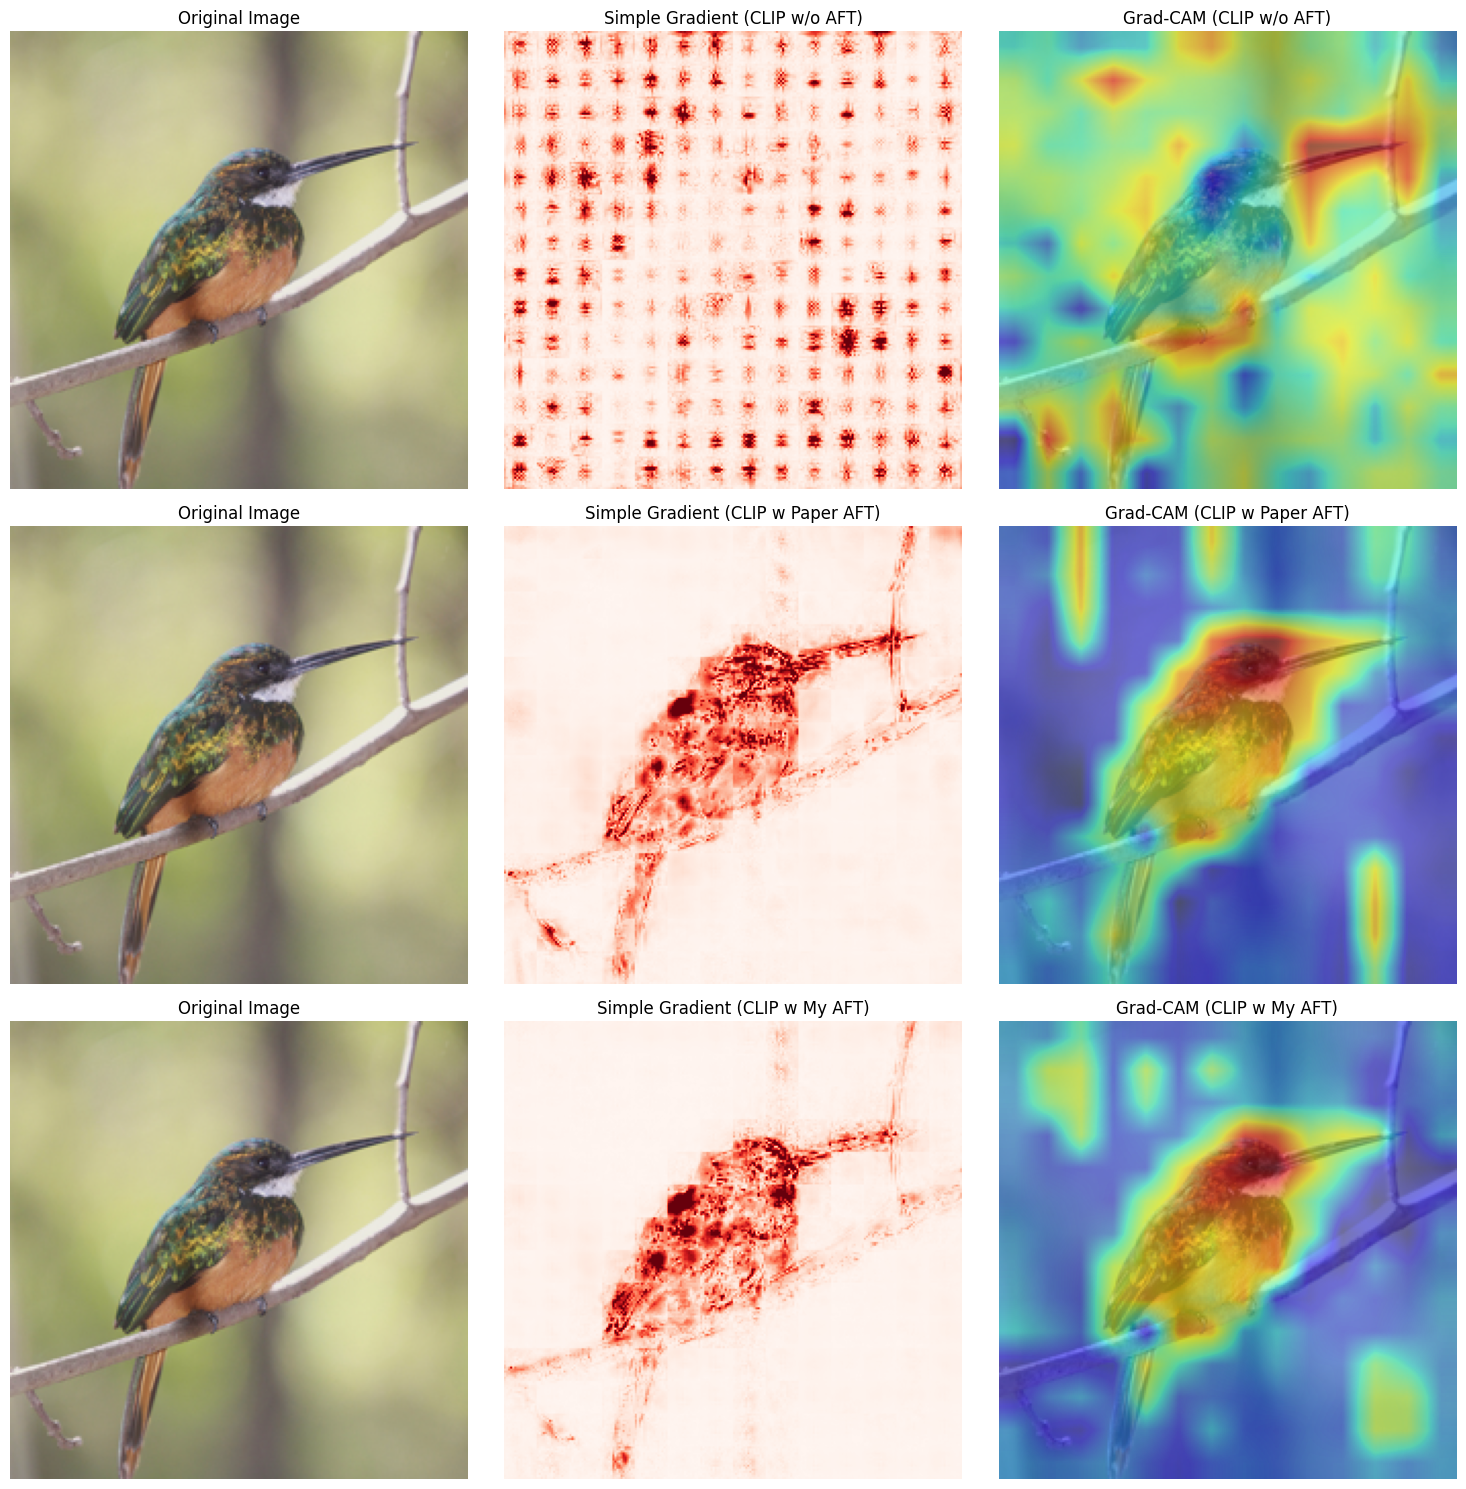

In [11]:
image_path, label = get_random_path()
prompt = "" or label

image, image_for_vis = preprocess_image(image_path, image_processor, device)
text_features = compute_text_features(prompt, model)

grad_map_orig = compute_simple_gradient(image, model_orig, text_features)
cam_map_orig = compute_vit_gradcam(image, model_orig, text_features)

grad_map_paper = compute_simple_gradient(image, model, text_features)
cam_map_paper = compute_vit_gradcam(image, model, text_features)

grad_map_my = compute_simple_gradient(image, my_model, text_features)
cam_map_my = compute_vit_gradcam(image, my_model, text_features)


print("Prompt: ", prompt)

show_all_maps(
    image_for_vis,
    grad_map_orig, cam_map_orig,
    grad_map_paper, cam_map_paper,
    grad_map_my, cam_map_my
)


In [16]:
model = model.visual
my_model = my_model.visual
model_orig = model_orig.visual

In [30]:
def patch_model_attention(model):
    original_forward = model.transformer.resblocks[-1].attn.forward

    def custom_forward(self, query, key, value, **kwargs):
        kwargs['need_weights'] = True
        kwargs['average_attn_weights'] = False
        attn_output, attn_weights = original_forward(query, key, value, **kwargs)
        self._last_attn_weights = attn_weights
        return attn_output, attn_weights

    model.transformer.resblocks[-1].attn.forward = types.MethodType(custom_forward, model.transformer.resblocks[-1].attn)


def get_cls_attention_map(model, image, patch_size=16):
    _ = model(image)
    attn_weights = model.transformer.resblocks[-1].attn._last_attn_weights
    attn = attn_weights[0]
    cls_attn = attn[:, 0, 1:]
    avg_cls_attn = cls_attn.mean(dim=0)
    return avg_cls_attn.reshape(14, 14).detach().cpu().numpy()



In [35]:
def plot_attention_comparison(images_for_vis, attention_sets, model_names, title="Attention Comparison", cmap='viridis'):

    num_images = len(images_for_vis)
    num_models = len(attention_sets)

    fig, axes = plt.subplots(num_models + 1, num_images, figsize=(3 * num_images, 3 * (num_models + 1)))

    for col in range(num_images):
        axes[0, col].imshow(images_for_vis[col])
        axes[0, col].axis('off')

    for row in range(num_models):
        for col in range(num_images):
            axes[row + 1, col].imshow(attention_sets[row][col], cmap=cmap)
            axes[row + 1, col].axis('off')

    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(left=0.15, wspace=0.05, hspace=0.05)
    plt.show()


(tensor([[[-0.0394,  0.0974,  0.4767,  ..., -0.0247,  0.3036, -0.3157]],

        [[ 0.0408, -0.2455,  0.2207,  ..., -0.0858,  0.3278, -0.2204]],

        [[ 0.0567, -0.2443,  0.2132,  ..., -0.0962,  0.3451, -0.2093]],

        ...,

        [[ 0.1633, -0.2718,  0.2289,  ..., -0.1322,  0.3140, -0.1465]],

        [[ 0.1378, -0.2804,  0.2084,  ..., -0.1180,  0.3141, -0.1811]],

        [[ 0.1025, -0.2513,  0.2072,  ..., -0.1019,  0.2974, -0.2090]]],
       device='cuda:0', grad_fn=<ViewBackward0>), tensor([[[[2.1085e-01, 7.7915e-04, 6.5188e-04,  ..., 2.1010e-04,
           3.5746e-04, 3.9628e-04],
          [7.8407e-02, 3.8948e-03, 3.8223e-03,  ..., 2.1606e-03,
           2.4111e-03, 2.8124e-03],
          [9.2158e-02, 3.7949e-03, 3.9165e-03,  ..., 1.7332e-03,
           1.8624e-03, 2.1759e-03],
          ...,
          [4.8900e-02, 1.8965e-03, 1.4747e-03,  ..., 3.1845e-03,
           4.2774e-03, 4.3206e-03],
          [5.0199e-02, 1.7349e-03, 1.5196e-03,  ..., 3.1458e-03,
           5.

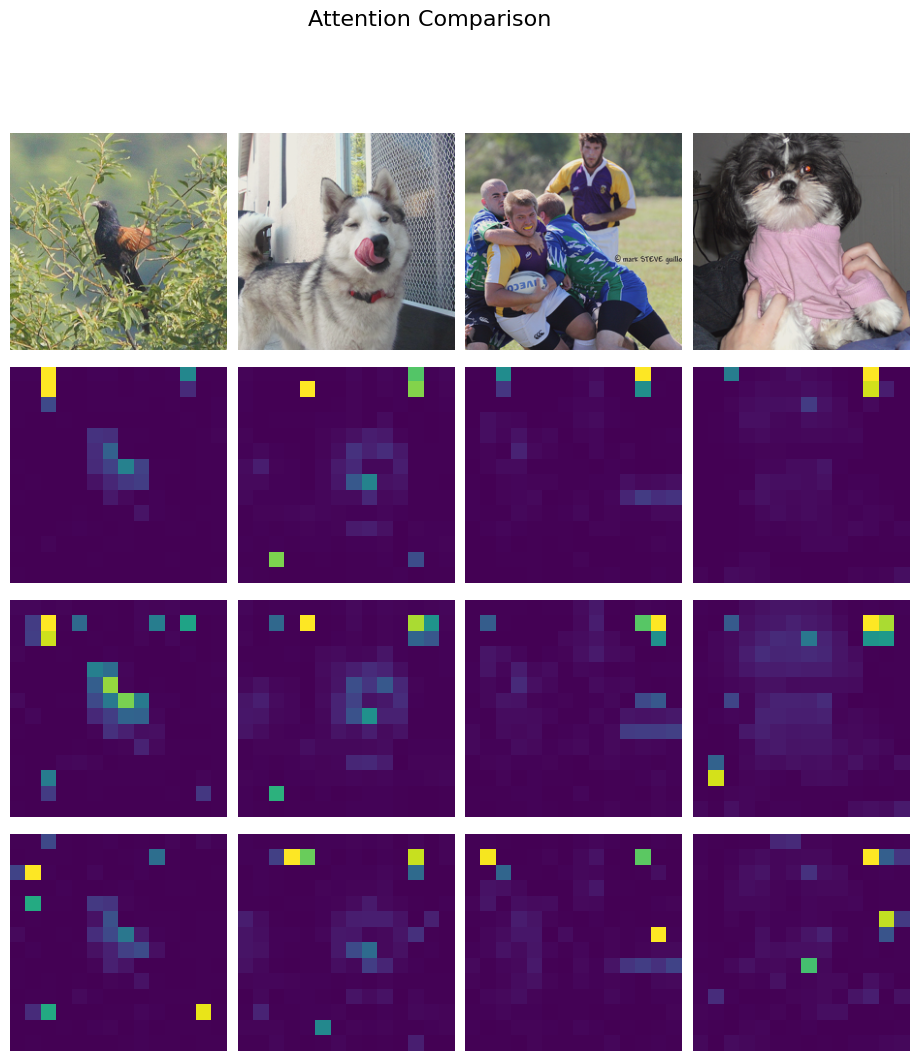

In [36]:
images_for_vis = []
attn_model = []
attn_my_model = []
attn_orig = []

for _ in range(4):
    image_path, label = get_random_path()
    image, image_for_vis = preprocess_image(image_path, image_processor, device)
    images_for_vis.append(image_for_vis)

    attn_model.append(get_cls_attention_map(model, image))
    attn_my_model.append(get_cls_attention_map(my_model, image))
    attn_orig.append(get_cls_attention_map(model_orig, image))


plot_attention_comparison(
    images_for_vis=images_for_vis,
    attention_sets=[attn_model, attn_my_model, attn_orig],
    model_names=["clip w/ AFT Paper", "clip w/ AFT Mine", "clip original"]
)
